In [166]:
import pandas as pd

pathLyrics = "./song-lyrics/lyrics-data.csv"
pathArtists = "./song-lyrics/artists-data.csv"

dataframeLyrics = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

#Only English + lowercase
dataLyricsFilterd = dataframeLyrics[dataframeLyrics['Idiom'] == 'ENGLISH']
#dataLyricsFilterd = dataLyricsFilterd[dataLyricsFilterd['Lyric'] != 'Instrumental']
#dataLyricsFilterd = dataLyricsFilterd[dataLyricsFilterd['Lyric'] != 'Instrumental.']

dataLyricsFilterd = dataLyricsFilterd.apply(lambda x: x.astype(str).str.lower())
dataArtistsFilterd = dataframeArtists.apply(lambda x: x.astype(str).str.lower())


del dataArtistsFilterd['Genres']
del dataArtistsFilterd['Popularity']
del dataArtistsFilterd['Songs']


#print(first)

#print(dataLyricsFilterd)

dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'samba']
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'sertanejo']
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'funk carioca']

#Doppelte Artists ignorieren - erster Artist wird genommen
sorted = dataArtistsFilterd.sort_values(['Link'])

dataArtistsFilterd = sorted.groupby('Link').first().reset_index()

i = dataArtistsFilterd

#Kleinere Datenmenge!!
test = i[i['Artist'] == '10000 maniacs' ]
#print(test)
test2 = i[i['Artist'] == 'will.i.am' ]
test3 = i[i['Artist'] == 'jennifer lopez' ]
#test2


test = test.append(test2)
test = test.append(test3)
#Hier ungewünschte Begriffe einfügen
patternDel = ["---", "instrumental","==="]
for patt in patternDel:
    filter = dataLyricsFilterd['Lyric'].str.contains(patt)
    dataLyricsFilterd = dataLyricsFilterd[~filter]

      
    
    
#dataArtistsFilterd = test
#dataLyricsFilterd.to_csv('filterdData.csv')
#test
#dataArtistsFilterd

In [167]:
print(dataArtistsFilterd)
mergedData = pd.merge(dataLyricsFilterd, dataArtistsFilterd, how='inner', left_on='ALink',right_on='Link')

#print(mergedData)
del mergedData['ALink']
del mergedData['SName']
del mergedData['SLink']
del mergedData['Idiom']
del mergedData['Artist']
del mergedData['Link']
#mergedData
#mergedData.to_csv('mergedData.csv')

                       Link               Artist    Genre
0              /021-funcao/           021 função  hip hop
1           /10000-maniacs/        10000 maniacs     rock
2               /12-stones/            12 stones     rock
3                  /14-bis/               14 bis      pop
4                    /18-k/                 18 k  hip hop
...                     ...                  ...      ...
1980              /zona-22/              zona 22     rock
1981               /zootak/               zootak  hip hop
1982     /zulluu-predileto/     zulluu predileto  hip hop
1983  /zumzera-e-guilherme/  zumzera e guilherme     rock
1984               /zz-top/               zz top     rock

[1985 rows x 3 columns]


<AxesSubplot:>

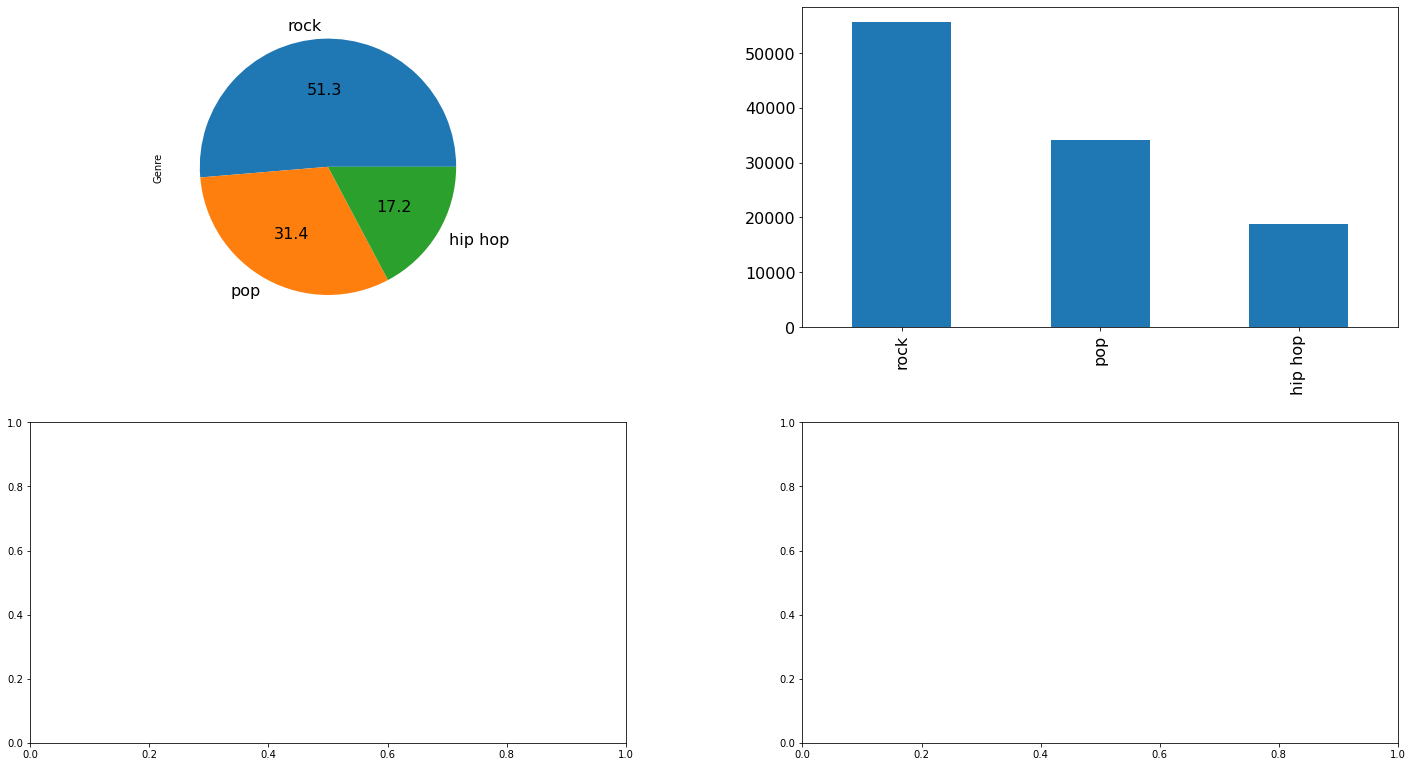

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt


genreCount = mergedData['Genre'].value_counts()

fig, axarr = plt.subplots(2, 2)
fig.tight_layout()


genreCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[0][0] , autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[0][1] )



In [169]:
from collections import Counter 

replacement = {',','.','(',')','[chorus:]','-','/','?','!','[','&',']','"'}

for index, lyric in enumerate(mergedData["Lyric"]):
    for repl in replacement:
        mergedData["Lyric"][index] = mergedData["Lyric"][index].replace(repl, ' ')
        
word_index = Counter(" ".join(mergedData["Lyric"]).split()).most_common(10000)




#for repl in replacement:
 #   string_temp = string_temp.replace(repl, ' ')
    #mergedData["Lyric"] = mergedData["Lyric"].replace(repl, ' ')

#word_index = Counter(" ".join(mergedData["Lyric"]).split()).most_common(1000)
#word_index = Counter(string_temp.split()).most_common(10000)
print(word_index)
#print(mergedData["Lyric"])

[('the', 1116285), ('you', 1115531), ('i', 1106535), ('to', 654923), ('and', 636038), ('a', 585015), ('me', 535824), ('it', 443586), ('my', 431755), ('in', 376716), ("i'm", 302500), ('on', 294624), ('that', 294278), ('your', 291042), ('of', 271556), ('all', 237676), ('we', 222070), ('be', 221606), ('is', 214319), ('for', 207337), ("don't", 206577), ('like', 202766), ('know', 198888), ('so', 198057), ('love', 186009), ('up', 183288), ('but', 177872), ('with', 171560), ('just', 168538), ('this', 166682), ("it's", 161588), ('no', 158284), ('oh', 157496), ('what', 151663), ('got', 150746), ('when', 147583), ('do', 146868), ('get', 146694), ('can', 137178), ('now', 134421), ('if', 122481), ('go', 120671), ('out', 117870), ('down', 110816), ('yeah', 107933), ('baby', 106784), ("you're", 105216), ('one', 104049), ('see', 101542), ('they', 99025), ('time', 96484), ('never', 94871), ('she', 91072), ('want', 90760), ('was', 89430), ('not', 88731), ("can't", 88601), ('are', 88035), ('let', 85654)

In [170]:
#most_common = set([t[0] for t in word_index]) 
most_common = []
for t in word_index:
    most_common.append(t[0])
    
print(len(most_common))    
#print(most_common)
xdata = []
xdata_boolean = []
ydata = []
ydata_integer = []
xdata_count = []
for lyric in mergedData['Lyric']:
    lyric_words_count = []
    cleared_lyrics_boolean = []
    for words in most_common:
        lyric_words_count.append(lyric.count(words))
        if lyric_words_count[-1] != 0:
            cleared_lyrics_boolean.append(1)
        else:
            cleared_lyrics_boolean.append(lyric_words_count[-1])
    xdata_count.append(lyric_words_count)
    xdata_boolean.append(cleared_lyrics_boolean)
print(xdata_count[0])    
    
    #lyric_words = lyric.split()
    #cleared_lyrics = ''
    #cleared_lyrics_boolean = []
    #for word in lyric_words:
    #    if word in most_common:
    #        cleared_lyrics += word + ' '
    #for words in most_common:
    #    if words in lyric:
    #        cleared_lyrics_boolean.append(1)
    #    else:
            #print("Nicht Vorhanden "+words)
    #        cleared_lyrics_boolean.append(0)
    #xdata.append(cleared_lyrics)
    #xdata_boolean.append(cleared_lyrics_boolean)
#print(xdata_boolean[0])      
    #print("Lyric Normal:")
    #print(lyric)
    #print("Lyric Cleared:")
    #print(cleared_lyrics)

    
    
for genre in mergedData['Genre']:
    if genre == "rock": 
        ydata_integer.append([1,0,0]);
        ydata.append(0);
    
    elif genre == "pop": 
        ydata_integer.append([0,1,0]);
        ydata.append(1);
     
    elif genre == "hip hop": 
        ydata_integer.append([0,0,1]);
        ydata.append(2);
        
#print (ydata_integer)

    #ydata.append(genre)
    

10000
[18, 5, 40, 0, 0, 36, 4, 1, 0, 21, 1, 5, 0, 0, 4, 1, 1, 1, 9, 1, 0, 1, 7, 0, 0, 0, 0, 0, 0, 9, 0, 18, 0, 0, 0, 0, 0, 0, 2, 7, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 1, 0, 0, 0, 3, 6, 0, 1, 0, 0, 2, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 10, 0, 0, 1, 0, 0, 10, 0, 3, 7, 20, 0, 8, 0, 1, 9, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 1, 9, 0, 9, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [171]:
import numpy as np
from keras import models
from keras import layers
import keras as keras

from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(xdata_count,ydata_integer, test_size=0.2)

def vectorize_sequences(sequences, dimensions=1000):
    results = np.zeros((len(sequences), dimensions))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

#print(test_data)

#X_train = vectorize_sequences(train_data)
#X_test = vectorize_sequences(test_data)
X_train = np.asarray(train_data).astype('float32')
X_test = np.asarray(test_data).astype('float32')

#print(test_labels)

#print(X_train)
#print(train_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#print(X_train)

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
keras.utils.plot_model(model, show_shapes=True)

history = model.fit(X_train, y_train, epochs=25, batch_size=100, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 128)               1280128   
_________________________________________________________________
dense_132 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_133 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_134 (Dense)            (None, 3)                 99        
Total params: 1,290,563
Trainable params: 1,290,563
Non-trainable params: 0
_________________________________________________________________
Train on 69457 samples, validate on 17365 samples
Epoch 1/25
69457/69457 [==============================] - 33s 478us/step - loss: 0.5962 - accuracy: 0.7122 - val_loss: 0.5773 - val_accuracy: 0.6922
Epoch 2/25
69457/69457 [==================

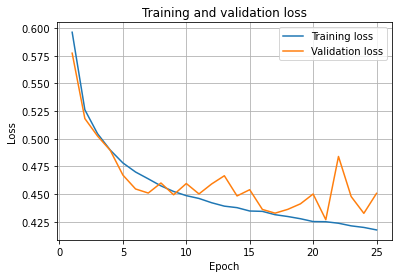

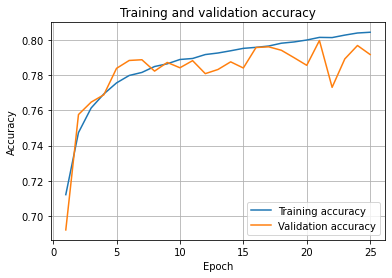

In [174]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

train_data, test_data, train_labels, test_labels = train_test_split(xdata_boolean,ydata, test_size=0.2)


X_train = np.asarray(train_data).astype('float32')
X_test = np.asarray(test_data).astype('float32')

#print(test_labels)

#print(X_train)
#print(train_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')






## Naive Bayes mit additiver Glättung trainieren
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)

## Vorhersagen berechnen
y_predicted = nb.predict(X_test)

## Konfusionsmatrix ausgeben
print("Kofusionsmatrix:\n", confusion_matrix(y_true=y_test, y_pred=y_predicted))

## Gütemaße ausgeben
print("Korrektklassifizierungsrate:\n", accuracy_score(y_true=y_test, y_pred=y_predicted))
print("Präzision (mikro):\n", precision_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("Ausbeute (mikro):\n", recall_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("F1 (mikro):\n", f1_score(y_true=y_test, y_pred=y_predicted, average='micro'))

In [61]:
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
# number of most frequent words to consider
num_words = 1000
# maximum length of lyrics (only the first so many words are considered)
max_len = 5920
# embedding dimensionality
emb_dim = 32
# describe model architecture
model = Sequential()
model.add(Embedding(num_words, emb_dim, input_length=max_len))
model.add(SimpleRNN(32, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 278 samples, validate on 70 samples
Epoch 1/10
278/278 [==============================] - 39s 140ms/step - loss: 0.6994 - acc: 0.5312 - val_loss: 0.6800 - val_acc: 0.6667
Epoch 2/10
278/278 [==============================] - 41s 149ms/step - loss: 0.6912 - acc: 0.5552 - val_loss: 0.6812 - val_acc: 0.6238
Epoch 3/10
278/278 [==============================] - 38s 137ms/step - loss: 0.7038 - acc: 0.5240 - val_loss: 0.6782 - val_acc: 0.6286
Epoch 4/10
278/278 [==============================] - 41s 146ms/step - loss: nan - acc: 0.4928 - val_loss: nan - val_acc: 0.0000e+00
Epoch 5/10
278/278 [==============================] - 39s 140ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 6/10
278/278 [==============================] - 39s 139ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 7/10
278/278 [==============================] - 39s 141ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 